In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from src.utils import load, add_variables, clean_data
from src.preprocessing import DataSet
from src.forecast import ARIMA, TSCV
from src.ploting import LinearPlot, DistPlot, ACFPlot, QQPlot
from src.utils import GridSearch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import jarque_bera
from scipy import stats

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

In [2]:
CURRENCY = "EURUSD"
INTERVAL = "4h"

In [3]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_value'])
train, val, test = data.add_variables().clean_data().normalize(how="standarize").get_tvt_df()

PACF plot of target_value variable

/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: 


<Axes: >

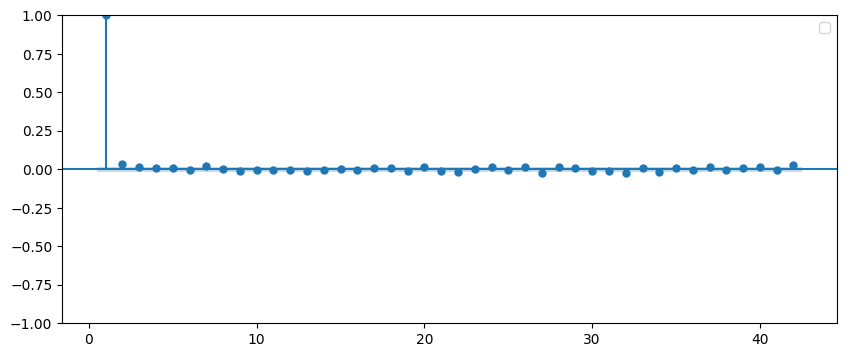

In [4]:
ACFPlot(legend=True).plot(train['target_value'], partial=True, legend="ACFPlot")

Durbin Watson test for lag 1 autocorrelation

In [5]:
durbin_watson(train['target_value'])

4.2729243e-06

ADfuller test for stationarity

In [6]:
for k in range(4):
    ts = train['target_value'].diff(k).dropna() if k !=0 else train['target_value']
    adf_res = adfuller(ts)
    print(f"k={k}, p-value: {adf_res[1]}, adf statistic: {adf_res[0]}")

k=0, p-value: 0.325144563894193, adf statistic: -1.9147710546888095
k=1, p-value: 0.0, adf statistic: -130.08637773355676
k=2, p-value: 0.0, adf statistic: -19.740014395144676
k=3, p-value: 0.0, adf statistic: -19.092713926413374


In [7]:
eurusd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24565 entries, 2011-08-17 16:00:00 to 2022-11-01 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    18050 non-null  float32
 1   Low     18050 non-null  float32
 2   High    18050 non-null  float32
 3   Close   18050 non-null  float32
 4   Volume  24565 non-null  float32
dtypes: float32(5)
memory usage: 671.7 KB


# ARIMA

In [8]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=700,
            test_size=5)
tscv.run(ARIMA(), p=2, d=1, q=4)

In [30]:
tscv.model.model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           target_value   No. Observations:                17496
Model:                 ARIMA(2, 1, 4)   Log Likelihood               80186.875
Date:                Sun, 30 Apr 2023   AIC                        -160359.750
Time:                        20:17:35   BIC                        -160305.362
Sample:                             0   HQIC                       -160341.840
                              - 17496                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5486      0.002   -227.199      0.000      -0.553      -0.544
ar.L2         -0.0255      0.003     -7.305      0.000      -0.032      -0.019
ma.L1          0.5136      0.002    208.129      0.000       0.509       0.518
ma.L2         -0.0004      0.004     -0.122      0.903      -0.007       0.007
ma.L3         -0.0070      0.008     -0.908      0.364      -0.022       0.008
ma.L4         -0.0060      0.007     -0.915      0.360      -0.019       0.007
sigma2      6.103e-06   2.74e-08    223.083      0.000    6.05e-06    6.16e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             70586.72
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.51e+17. Standard errors may be unstable.
"""

saving: ARIMA
saving: ARIMA


<Axes: title={'center': 'ARIMA'}>

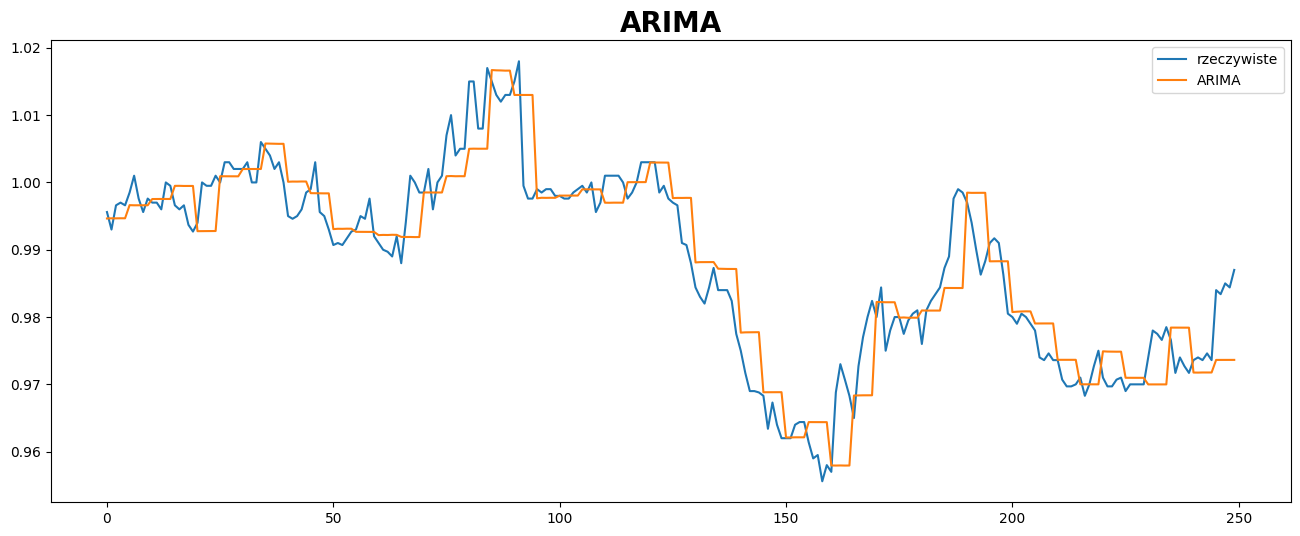

In [29]:
pred_y = tscv.predicted
x = tscv.dataset.data.index[-len(pred_y):]


lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(range(len(pred_y)), tscv.dataset.data.loc[x, 'target_value'], label="rzeczywiste", title="ARIMA")
lp.plot(range(len(pred_y)), pred_y, label="ARIMA")

# GridSearch ARIMA

In [8]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=700,
            test_size=5)

warnings.filterwarnings('ignore')
gs = GridSearch(model=ARIMA(),
                tscv=tscv,
                params={'p': [1, 2, 3, 4], 'd': [1], 'q': [1, 2, 3, 4]},
                by=['rmspe'],
                p_count=5)
gs.run() # already been run, best model: ARIMA(2, 1, 4)

split: 1/700
split: 2/700
split: 3/700
split: 4/700
split: 5/700
split: 6/700
split: 7/700
split: 8/700
split: 9/700
split: 10/700
split: 11/700
split: 12/700
split: 13/700
split: 14/700
split: 15/700
split: 16/700
split: 17/700
split: 18/700
split: 19/700
split: 20/700
split: 21/700
split: 22/700
split: 23/700
split: 24/700
split: 25/700
split: 26/700
split: 27/700
split: 28/700
split: 29/700
split: 30/700
split: 31/700
split: 32/700
split: 33/700
split: 34/700
split: 35/700
split: 36/700
split: 37/700
split: 38/700
split: 39/700
split: 40/700
split: 41/700
split: 42/700
split: 43/700
split: 44/700
split: 45/700
split: 46/700
split: 47/700
split: 48/700
split: 49/700
split: 50/700
split: 51/700
split: 52/700
split: 53/700
split: 54/700
split: 55/700
split: 56/700
split: 57/700
split: 58/700
split: 59/700
split: 60/700
split: 61/700
split: 62/700
split: 63/700
split: 64/700
split: 65/700
split: 66/700
split: 67/700
split: 68/700
split: 69/700
split: 70/700
split: 71/700
split: 72/700
s

# Model evaluation

In [4]:
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=5)
tscv.run(ARIMA(), p=2, d=1, q=4)

split: 1/3
split: 2/3
split: 3/3


{'mean_absolute_percentage_error': 0.002140543407608655,
 'rmspe': 0.0028841502400008545}

In [5]:
resid = tscv.model.model_fit.resid[1:]

### Residuals distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Rozkład reszt ARIMA
saving: Wykres liniowy reszt ARIM


<Axes: title={'center': 'Wykres liniowy reszt ARIM'}>

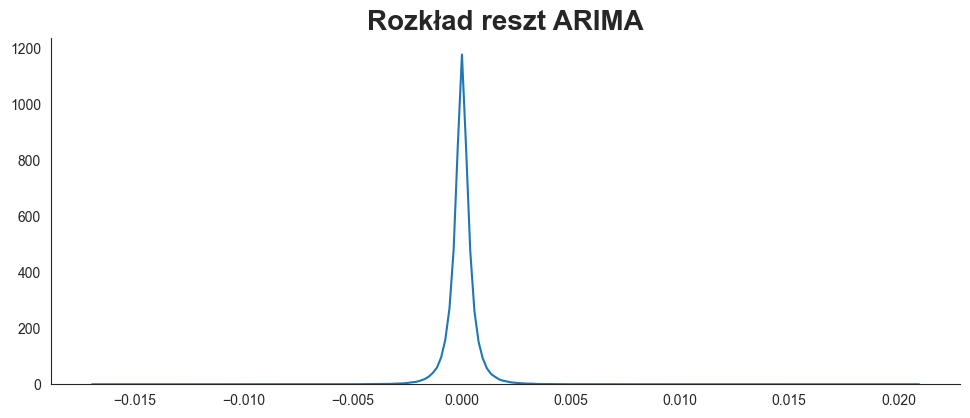

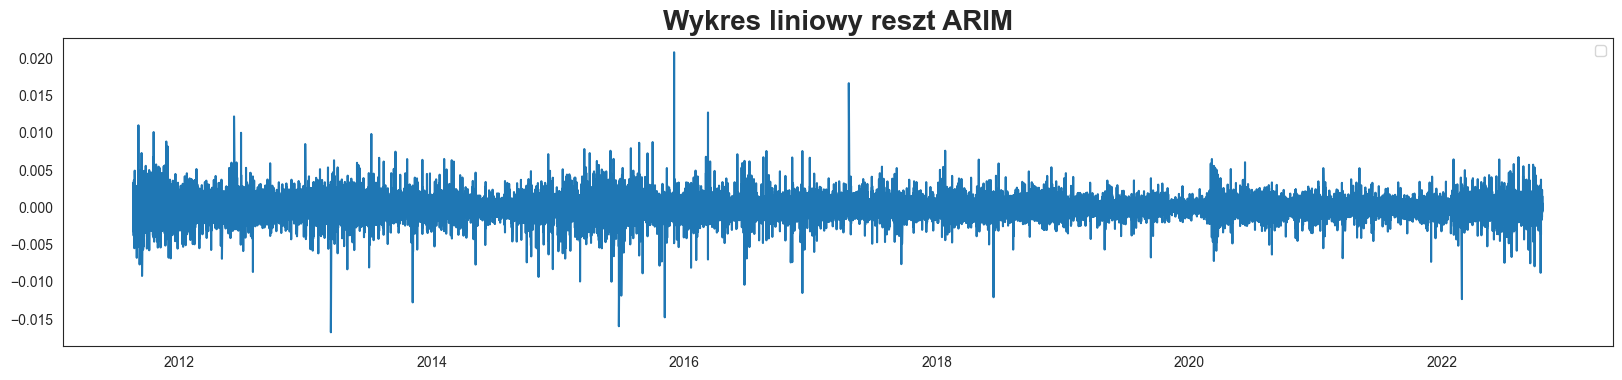

In [6]:
DistPlot().plot(resid, title="Rozkład reszt ARIMA")
LinearPlot(w=20).plot(tscv.dataset.train.index[1:], resid, title="Wykres liniowy reszt ARIM")

In [7]:

jarque_bera(resid)

SignificanceResult(statistic=9869872.949989887, pvalue=0.0)

In [8]:
ind = np.argpartition(np.abs(resid), -100)[-100:]
top_100 = resid[ind].sort_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Rozkład reszt ARIMA
saving: Wykres liniowy reszt ARIM


<Axes: title={'center': 'Wykres liniowy reszt ARIM'}>

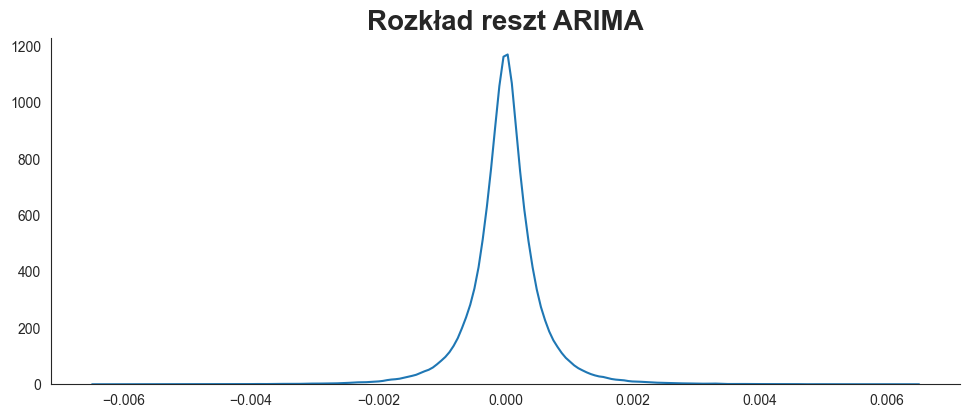

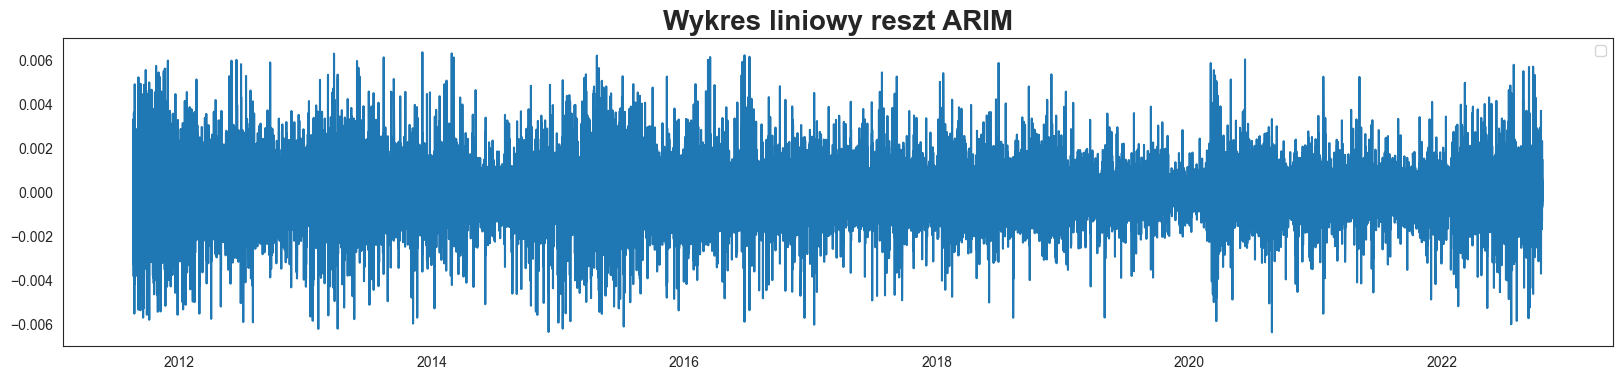

In [9]:
r_2 = resid.drop(index=top_100.index)
DistPlot().plot(r_2, title="Rozkład reszt ARIMA")
LinearPlot(w=20).plot(r_2.index, r_2, title="Wykres liniowy reszt ARIM")

In [10]:
jarque_bera(resid)

SignificanceResult(statistic=9869872.949989887, pvalue=0.0)

In [11]:
print(f"skewenes: {stats.skew(resid)}\nkurtosis: {stats.kurtosis(resid)}")

skewenes: -0.039160365299973014
kurtosis: 29.23606079395823


### Residuals autocorrelation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


saving: ACF reszt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: PACF reszt


<Axes: title={'center': 'PACF reszt'}>

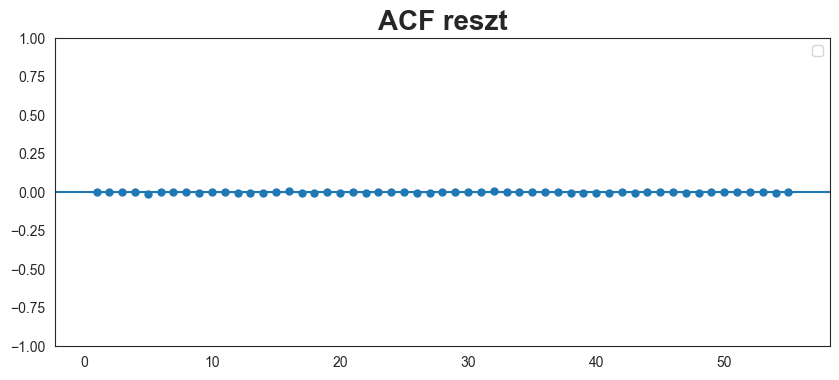

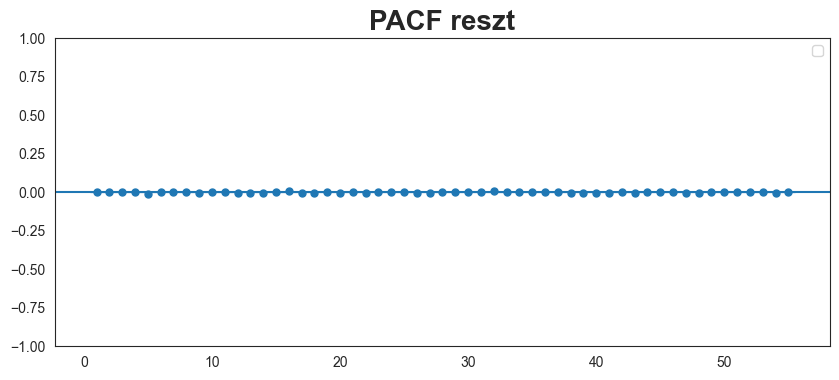

In [12]:
ACFPlot().plot(resid, title="ACF reszt")
ACFPlot().plot(resid, title="PACF reszt", partial=True)

In [13]:

durbin_watson(resid)

2.0002075949789897

### Heteroskedasticity 

saving: Wykres kwantylowy


<Axes: title={'center': 'Wykres kwantylowy'}, xlabel='Reszty teoretyczne', ylabel='Reszty rzeczywiste'>

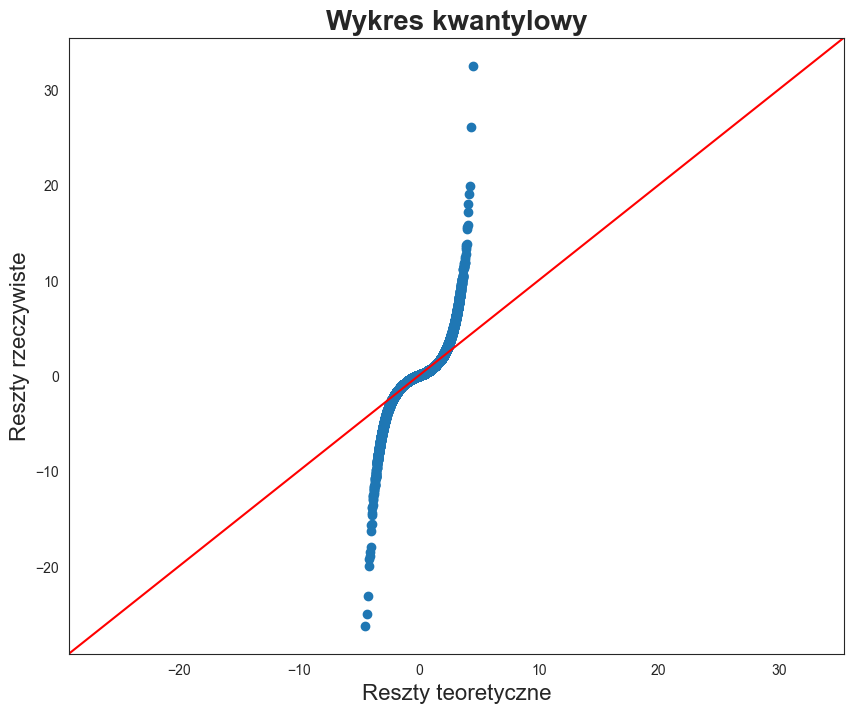

In [35]:
QQPlot(legend=False, w=10, h=8).plot(resid, title="Wykres kwantylowy", xlabel="Reszty teoretyczne", ylabel="Reszty rzeczywiste")

In [15]:
het_breuschpagan(resid, tscv.dataset.train[['Close', 'target_value']].iloc[1:])

(8658.006531606448, 0.0, 4468.578420869463, 0.0)